# Sentiment analysis COVID-19 scholar's articles

# Imports

In [1]:
import os
import json
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from  nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.collocations import *
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')
style.use('ggplot')
np.random.seed(0)
import tensorflow as tf

import numpy as np
import os
import time

In [2]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import sys

Using TensorFlow backend.


In [3]:
ls

 Volume in drive C is OS
 Volume Serial Number is D816-28B0

 Directory of C:\Users\luigi\FlatironSchool\personal_project

25/04/2020  12:57    <DIR>          .
25/04/2020  12:57    <DIR>          ..
23/03/2020  14:33    <DIR>          .ipynb_checkpoints
23/03/2020  14:30    <DIR>          biorxiv_medrxiv
23/03/2020  14:13    <DIR>          comm_use_subset
21/03/2020  00:32            26,690 COVID.DATA.LIC.AGMT.pdf
25/04/2020  12:57            38,009 COVID-19.ipynb
23/03/2020  14:13    <DIR>          custom_license
21/03/2020  00:37             2,906 json_schema.txt
21/03/2020  00:37             1,574 metadata.readme
25/04/2020  13:49    <DIR>          models
23/03/2020  14:14    <DIR>          noncomm_use_subset
               4 File(s)         69,179 bytes
               8 Dir(s)   5,592,252,416 bytes free


# See documents README

In [4]:
with open('metadata.readme', 'r') as f:
    data = f.read()
    print(data)

(1) Metadata for papers from these sources are combined: CZI, PMC, BioRxiv/MedRxiv. (total records 29500)
	- CZI 1236 records
	- PMC 27337
	- bioRxiv 566
	- medRxiv 361
(2) 17K of the paper records have PDFs and the hash of the PDFs are in 'sha'
(3) For PMC sourced papers, one paper's metadata can be associated with one or more PDFs/shas under that paper - a PDF/sha correponding to the main article, and possibly additional PDF/shas corresponding to supporting materials for the article.
(4)	13K of the PDFs were processed with fulltext ('has_full_text'=True)
(5) Various 'keys' are populated with the metadata:
	- 'pmcid': populated for all PMC paper records (27337 non null)
	- 'doi': populated for all BioRxiv/MedRxiv paper records and most of the other records (26357 non null)
	- 'WHO #Covidence': populated for all CZI records and none of the other records (1236 non null)
	- 'pubmed_id': populated for some of the records
	- 'Microsoft Academic Paper ID': populated for some of the records


# Text generation with LSTM Recurrent Neural Network

In [5]:
directory = ['comm_use_subset']

In [6]:
documents = []
for d in directory:
    for index, file in enumerate(os.listdir(f"{d}/{d}")):
        file_path = f"{d}/{d}/{file}"
        j = json.load(open(file_path, 'rb'))

        title = j['metadata']['title']

        documents.append(title.lower())

In [7]:
str_doc = ''.join(documents)
#str_doc.replace(" ", "\n")

### Create a set of all of the distinct characters in the text, then create a map of each character to a unique integer

In [8]:
# create mapping of unique chars to integers
chars = sorted(list(set(str_doc)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [9]:
n_chars = len(str_doc)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  962962
Total Vocab:  288


In [10]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = str_doc[i:i + seq_length]
    seq_out = str_doc[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  962862


In [11]:
# reshape X to be [samples, time steps, features]
X = numpy.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [12]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [13]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min'))
callbacks_list = [checkpoint]

In [14]:
model.fit(X, y, epochs=3, batch_size=128, callbacks=callbacks_list, validation_split=0.2)

Train on 770289 samples, validate on 192573 samples
Epoch 1/3
770289/770289 [==============================] - 2126s 3ms/step - loss: 2.9718 - val_loss: 2.8713
Epoch 2/3
770289/770289 [==============================] - 2254s 3ms/step - loss: 2.8228 - val_loss: 2.7809
Epoch 3/3
770289/770289 [==============================] - 2188s 3ms/step - loss: 2.7412 - val_loss: 2.6929


In [16]:
# load the network weights
filename = "models/weights-improvement-03-2.7412.hdf5.model"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [17]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [19]:
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
print("-----------------------------")
# generate characters
for i in range(100):
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
" rial infectionsbayesian analysis for inference of an emerging epidemic: citrus canker in urban lands "
-----------------------------
e and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anil
Done.


In [20]:
# pick a random seed
start = numpy.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
print("-----------------------------")
# generate characters
for i in range(1000):
    x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")

Seed:
" l allogeneic bone marrow transplantationfrequency of respiratory virus infections and next-generatio "
-----------------------------
n of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and anilneation of tee ietere and

# Sentiment analysis

In [21]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\luigi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [22]:
sid = SentimentIntensityAnalyzer()

In [23]:
df_for_series = pd.DataFrame(documents, columns=['titles'])
df_for_series.head()

,titles
0,supplementary information an eco-epidemiologic...
1,immunity to pathogens taught by specialized hu...
2,public health responses to and challenges for ...
3,a section of the journal frontiers in pediatri...
4,mini review function of the deubiquitinating e...


In [24]:
compound_list = []
for x in documents:
    ss = sid.polarity_scores(x)
    compound_list.append(ss['compound'])

In [25]:
df_for_series['compound'] = compound_list
df_for_series.head()

,titles,compound
0,supplementary information an eco-epidemiologic...,0.0000
1,immunity to pathogens taught by specialized hu...,0.0000
2,public health responses to and challenges for ...,0.0772
3,a section of the journal frontiers in pediatri...,0.2263
4,mini review function of the deubiquitinating e...,-0.2732


In [26]:
df_for_series.tail()

,titles,compound
9113,comment,0.0000
9114,virology journal evidence of hiv-1 adaptation ...,0.0000
9115,the cientificworldjournal research article cli...,0.0000
9116,gaining insights into the codon usage patterns...,0.4215
9117,dengue virus glycosylation: what do we know?,0.0000


In [27]:
len(df_for_series)

9118

In [28]:
df_for_series['compound'].describe()

count    9118.000000
mean       -0.002457
std         0.263443
min        -0.963800
25%         0.000000
50%         0.000000
75%         0.000000
max         0.962800
Name: compound, dtype: float64

In [29]:
target_list = []
for x in df_for_series['compound']:
    if x < -.25:
        target_list.append(-1)
    elif x > .25:
        target_list.append(1)
    else: 
        target_list.append(0)

In [30]:
df_for_series['target'] = target_list
df_for_series.head(20)

,titles,compound,target
0,supplementary information an eco-epidemiologic...,0.0000,0
1,immunity to pathogens taught by specialized hu...,0.0000,0
2,public health responses to and challenges for ...,0.0772,0
3,a section of the journal frontiers in pediatri...,0.2263,0
4,mini review function of the deubiquitinating e...,-0.2732,-1
5,evaluation of the tuberculosis programme in ni...,0.0000,0
6,gpi-anchored single chain fv -an effective way...,0.4767,1
7,transmissible gastroenteritis virus infection ...,0.0000,0
8,chaperone-mediated autophagy protein bag3 nega...,0.0000,0
9,molecular sciences monocytes and macrophages a...,0.0000,0


In [31]:
import seaborn as sns

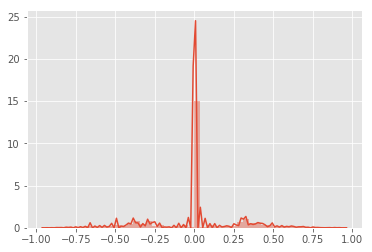

In [32]:
sns.distplot(compound_list);

# Create df for commercial articles

In [33]:
def create_df_text(directory): 
    
    ''' Create df with title, abstract and full text as columns
    
        Argument: directory: choose the directory needed
        
        Return: dataframe
    
    '''
    docs = []
    for d in directory:
        for index, file in enumerate(os.listdir(f"{d}/{d}")):
            file_path = f"{d}/{d}/{file}"
            j = json.load(open(file_path, 'rb'))

            title = j['metadata']['title']

            try:
                abstract = j['abstract'][0]['text']
            except:
                abstract = ""

            full_text = ""   
            for text in j['body_text']:
                full_text += text['text'] + "\n\n"


            docs.append([title, abstract, full_text])

            if index % 10 == 0:
                print(index, end=" ")
                
    df = pd.DataFrame(docs, columns = ['title', 'abstract', 'full_text'])
            
    return df

In [34]:
df_comm = create_df_text(directory)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 2100 2110 2120 2130 2140 2150 2160 2170 2180 2190 2200 2210 2

In [35]:
df_comm.head()

,title,abstract,full_text
0,Supplementary Information An eco-epidemiologic...,,- Figure S1 : Phylogeny of all sequences belon...
1,immunity to pathogens taught by specialized hu...,Dendritic cells (DCs) are specialized antigen-...,iNTRODUCTiON Human beings are constantly expos...
2,Public Health Responses to and Challenges for ...,Dengue has a negative impact in low-and lower ...,Pathogens and vectors can now be transported r...
3,a section of the journal Frontiers in Pediatri...,"Fifteen years ago, United Nations world leader...",In addition to preventative care and nutrition...
4,MINI REVIEW Function of the Deubiquitinating E...,Posttranslational modification of proteins by ...,Ubiquitination is a widely used posttranslatio...


In [36]:
df_comm.isnull().any()

title        False
abstract     False
full_text    False
dtype: bool

# Check articles that contain the word incubation

In [37]:
incubation = df_comm[df_comm['full_text'].str.contains('incubation')]
incubation.head()

,title,abstract,full_text
3,a section of the journal Frontiers in Pediatri...,"Fifteen years ago, United Nations world leader...",In addition to preventative care and nutrition...
6,GPI-anchored single chain Fv -an effective way...,Background: Identification of broad neutraliza...,Human Immunodeficiency Virus type 1 (HIV-1) en...
8,Chaperone-Mediated Autophagy Protein BAG3 Nega...,Ebola (EBOV) and Marburg (MARV) viruses are me...,Introduction Ebola (EBOV) and Marburg (MARV) v...
11,Rational Design of a Live Attenuated Dengue Va...,Dengue virus is transmitted by Aedes mosquitoe...,Dengue virus (DENV) is a member of the Flavivi...
12,The Domain-Specific and Temperature-Dependent ...,The implementation of expanded newborn screeni...,Medium-chain acyl-CoA dehydrogenase deficiency...


Let's write a regex for capture digits followed by the word day and save in a list.

In [38]:
incubation_time = []
texts = incubation['full_text'].values

for text in texts:
    for sentence in text.split(". "):
        if "incubation" in sentence:
            single_day = re.findall(r'( \d{1,2}(\.\d{1,2})? day[s]?)', sentence)
            
            if len(single_day) == 1:
                num = single_day[0][0].split(" ")
                incubation_time.append(float(num[1]))

In [39]:
print(len(incubation_time))
print(incubation_time, end=' ')

405
[2.5, 5.0, 5.0, 5.0, 3.0, 3.0, 3.0, 10.0, 5.2, 7.0, 2.0, 2.0, 2.0, 7.0, 4.0, 11.0, 11.0, 21.0, 2.0, 2.0, 5.0, 3.0, 5.2, 4.0, 4.0, 7.0, 5.2, 3.0, 5.0, 4.0, 14.0, 7.0, 4.0, 3.0, 28.0, 3.0, 2.0, 6.0, 2.0, 4.0, 3.0, 1.0, 3.0, 42.0, 42.0, 12.0, 14.0, 6.0, 3.0, 3.0, 4.0, 5.0, 7.0, 14.0, 5.6, 5.0, 5.0, 5.0, 14.0, 15.0, 56.0, 56.0, 3.0, 10.0, 6.0, 4.0, 2.0, 9.0, 16.0, 6.0, 3.0, 3.0, 3.0, 15.0, 21.3, 31.1, 28.0, 3.0, 3.0, 5.0, 4.0, 5.0, 16.0, 14.0, 6.0, 4.0, 5.0, 3.0, 7.0, 1.0, 8.0, 14.0, 10.0, 7.0, 7.0, 3.0, 2.0, 13.0, 14.0, 2.0, 14.0, 5.0, 7.0, 4.0, 5.0, 6.0, 4.0, 1.0, 4.0, 3.0, 2.0, 3.0, 21.0, 21.0, 3.0, 3.0, 6.0, 5.0, 3.4, 3.5, 1.9, 15.0, 4.0, 6.7, 2.0, 10.0, 3.0, 6.4, 11.1, 11.1, 14.0, 5.0, 3.0, 28.0, 15.0, 3.0, 5.2, 5.0, 7.0, 14.0, 10.0, 7.0, 13.0, 15.0, 10.0, 18.0, 7.0, 4.0, 5.0, 4.5, 2.0, 5.0, 1.2, 2.0, 5.0, 4.0, 3.0, 90.0, 90.0, 5.0, 21.0, 11.4, 6.0, 3.0, 4.0, 14.0, 14.0, 7.0, 3.0, 5.2, 3.67, 5.0, 6.0, 6.0, 3.0, 14.0, 3.0, 2.0, 3.0, 21.0, 5.0, 3.0, 4.0, 4.0, 5.0, 5.0, 2.0, 5.0, 3.0

I'm assuming that values over 30 are outliers so I'm gonna remove them.

In [40]:
inc_time = [i for i in incubation_time if i < 30]

In [41]:
df_inc = pd.DataFrame(inc_time, columns=['Incubation days'])
df_inc.head()

,Incubation days
0,2.5
1,5.0
2,5.0
3,5.0
4,3.0


In [42]:
df_inc.describe()

,Incubation days
count,394.000000
mean,7.169721
std,5.441486
min,1.000000
25%,3.000000
50%,5.000000
75%,10.000000
max,28.000000


### The mean of the commercial articles for the incubation days is 7 days.

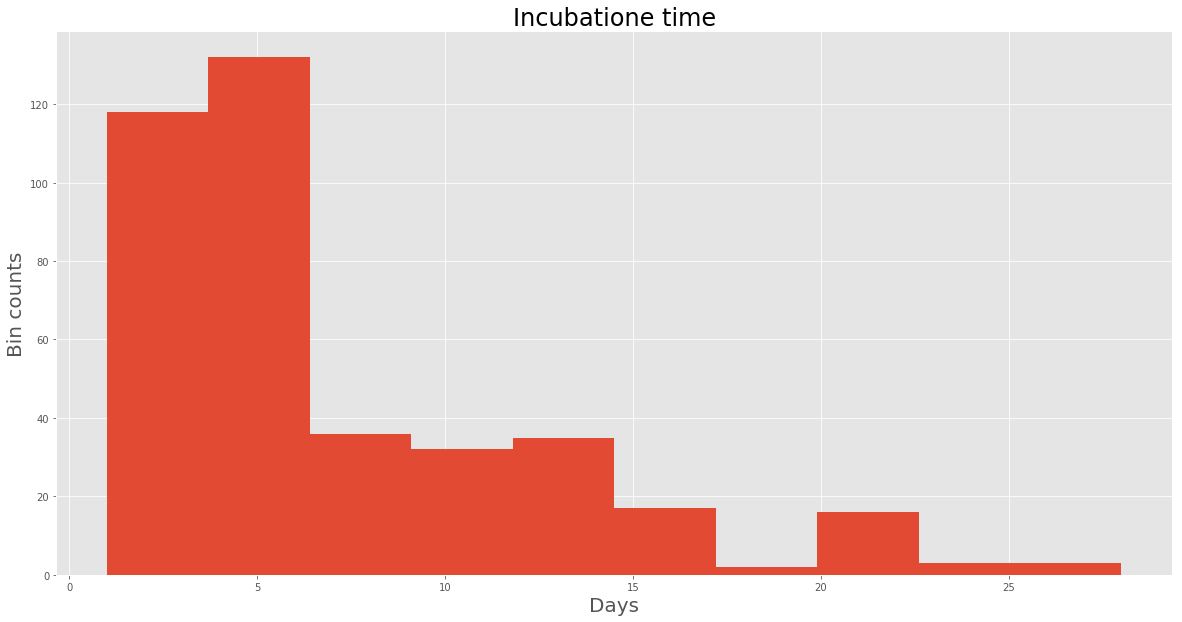

In [43]:
plt.figure(figsize=(20,10))
plt.hist(inc_time)
plt.title('Incubatione time', fontsize=24)
plt.ylabel('Bin counts', fontsize=20)
plt.xlabel('Days', fontsize=20);

# Create df for non commercial articles

In [44]:
directory = ['noncomm_use_subset']

In [45]:
df_non_comm = create_df_text(directory)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090 2100 2110 2120 2130 2140 2150 2160 2170 2180 2190 2200 2210 2

In [46]:
df_non_comm.head()

,title,abstract,full_text
0,The fecal microbiota and unconjugated fecal bi...,and Blautia (P = 0.008) significantly decrease...,human type 1 DM. The aim of this study was to ...
1,Development of a smartphone-based rapid dual f...,Accurate and rapid diagnosis of highly pathoge...,Avian influenza (AI) viruses are distinct from...
2,Dromedary camels in northern Mali have high se...,A high percentage (up to 90%) of dromedary cam...,Dromedary camels (Camelus dromedarius) appear ...
3,Regulated Export of a Secretory Protein from t...,"253 protein, C-reactive protein (CRPt), varies...",Abstract. The half-time for secretion of the p...
4,,,This is an Open Access article distributed und...


In [47]:
df_non_comm.isnull().any()

title        False
abstract     False
full_text    False
dtype: bool

# Check articles that contain the word incubation

In [48]:
incubation = df_non_comm[df_non_comm['full_text'].str.contains('incubation')]
incubation.head()

,title,abstract,full_text
0,The fecal microbiota and unconjugated fecal bi...,and Blautia (P = 0.008) significantly decrease...,human type 1 DM. The aim of this study was to ...
3,Regulated Export of a Secretory Protein from t...,"253 protein, C-reactive protein (CRPt), varies...",Abstract. The half-time for secretion of the p...
5,ULK1/2 Restricts the Formation of Inducible SI...,,Spatial and temporal organization of cellular ...
13,Structure-based identification of functional r...,Bluetongue virus (BTV) encodes a single cappin...,Eukaryotic cellular and most viral messenger R...
14,Comparative Evaluation of Three Homogenization...,Background: Real-time reverse transcription PC...,irrespective of the length of time between sym...


Let's write a regex for capture digits followed by the word day and save in a list.

In [49]:
incubation_time = []
texts = incubation['full_text'].values

for text in texts:
    for sentence in text.split(". "):
        if "incubation" in sentence:
            single_day = re.findall(r'( \d{1,2}(\.\d{1,2})? day[s]?)', sentence)
            
            if len(single_day) == 1:
                num = single_day[0][0].split(" ")
                incubation_time.append(float(num[1]))

In [50]:
print(len(incubation_time))
print(incubation_time, end=' ')

84
[14.0, 7.0, 5.0, 3.6, 14.0, 14.0, 5.2, 2.0, 28.0, 7.0, 14.0, 14.0, 5.0, 18.0, 28.0, 2.0, 8.0, 49.0, 4.0, 6.0, 13.0, 5.0, 5.0, 14.0, 2.0, 4.0, 6.0, 5.0, 5.0, 2.0, 5.0, 3.0, 6.0, 5.0, 7.0, 10.0, 7.0, 21.0, 12.0, 3.0, 14.0, 5.0, 14.0, 7.0, 4.0, 21.0, 14.0, 2.0, 4.0, 5.2, 5.0, 5.0, 4.0, 14.0, 1.0, 1.0, 7.0, 21.0, 5.0, 6.83, 14.0, 20.0, 2.0, 4.0, 5.2, 2.0, 17.0, 3.0, 6.0, 5.0, 4.0, 21.0, 14.0, 6.0, 28.0, 10.0, 17.0, 3.0, 5.0, 4.0, 15.0, 5.2, 5.2, 4.0] 

I'm assuming that values over 30 are outliers so I'm gonna remove them.

In [51]:
inc_time = [i for i in incubation_time if i < 30]

In [52]:
df_inc = pd.DataFrame(inc_time, columns=['Incubation days'])
df_inc.head()

,Incubation days
0,14.0
1,7.0
2,5.0
3,3.6
4,14.0


In [53]:
df_inc.describe()

,Incubation days
count,83.000000
mean,8.655783
std,6.609523
min,1.000000
25%,4.000000
50%,5.200000
75%,14.000000
max,28.000000


### The mean of the non commercial articles for the incubation days is 9 days.

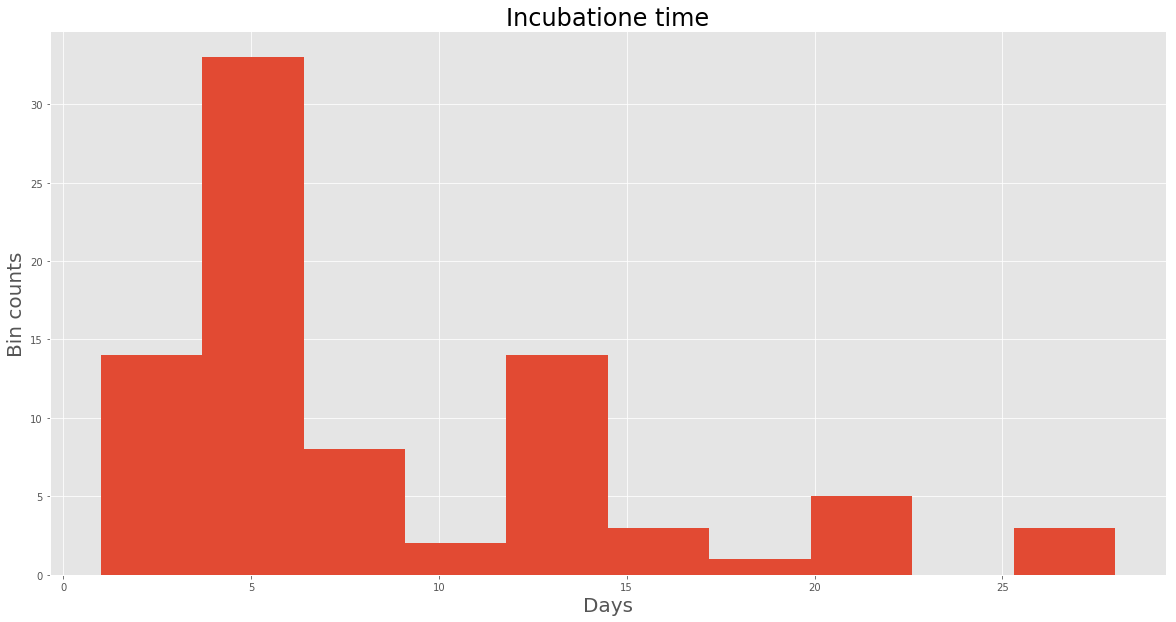

In [54]:
plt.figure(figsize=(20,10))
plt.hist(inc_time)
plt.title('Incubatione time', fontsize=24)
plt.ylabel('Bin counts', fontsize=20)
plt.xlabel('Days', fontsize=20);

# Preprocessing the Data

# Stopword and punctualization

In [55]:
# Get all the stop words in the English language
stopwords_list = stopwords.words('english')
stopwords_list = stopwords_list + ['the', 'a', 'in', 'al', 'c', 'et','e', 'study', 'virus', 'b','p', 
                      'using', 'also', 'infection', 'cell', 'h', 'n', 'protein']

In [56]:
# Now we have a list that includes all english stopwords, as well as all punctuation
stopwords_list += list(string.punctuation)

# Tokenizing our Data

In [57]:
def tokenize(text):
    joined_text = ' '.join(text)
    tokenized_text = word_tokenize(joined_text)
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    text_tokens_raw = nltk.regexp_tokenize(str(tokenized_text), pattern)
    stopped_tokens = [w.lower() for w in text_tokens_raw if w not in stopwords_list]
    
    return stopped_tokens

In [58]:
full_txt_list = []
for x in df_non_comm['full_text']:
    full_txt_list.append(x)

In [59]:
tokenized_full_txt = tokenize(full_txt_list)

In [60]:
tokenized_full_txt[:10]

['human',
 'type',
 'dm',
 'the',
 'aim',
 'evaluate',
 'changes',
 'fecal',
 'microbiota',
 'fecal']

# Count Vectorization.

In [61]:
def count_vectorize(text, vocab=None):
    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(text))
    
    txt_dict = {i:0 for i in unique_words}
    
    for word in text:
        txt_dict[word] += 1
    
    return txt_dict

In [62]:
test_vectorized = count_vectorize(tokenized_full_txt)

# Get the 50 most common words 

In [63]:
freqdist = FreqDist(tokenized_full_txt)

# get the 50 most common words 
most_common = freqdist.most_common(50)
print(most_common[:20], end = ' ')

[('the', 63219), ('cells', 34594), ('a', 30240), ('in', 26343), ('c', 22125), ('patients', 17070), ('may', 16270), ('used', 16151), ('data', 16041), ('s', 15526), ('viral', 14893), ('b', 14453), ('g', 14236), ('disease', 14175), ('fig', 13761), ('one', 13150), ('health', 12722), ('this', 12688), ('p', 12485), ('two', 12436)] 

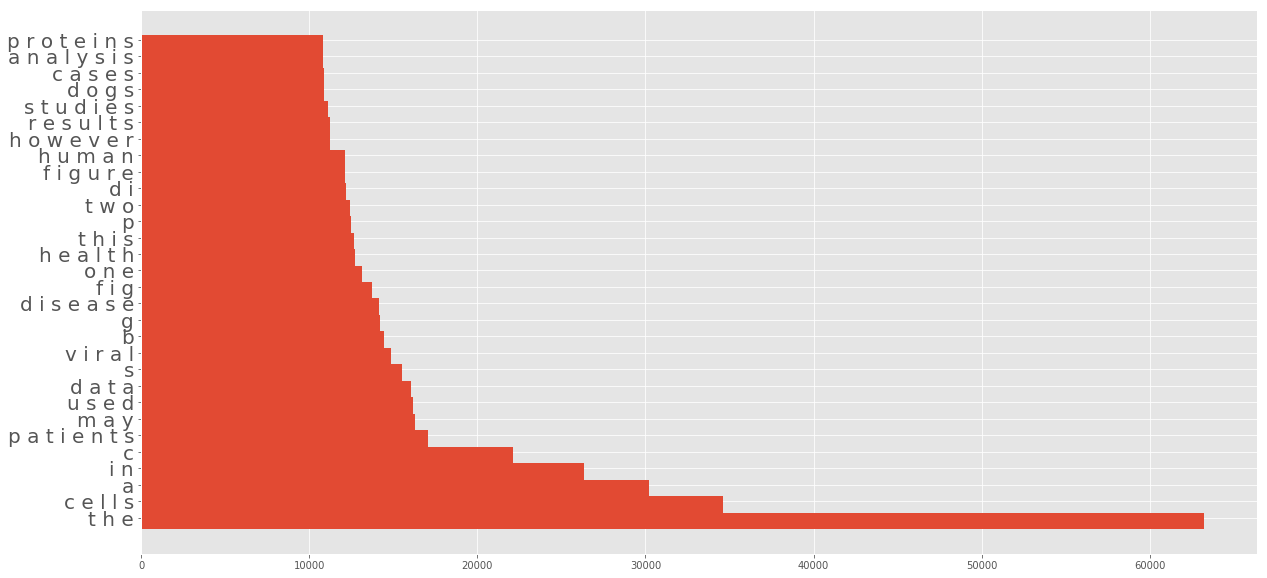

In [64]:
num_to_show = 30

labels = [" ".join(e[0]) for e in freqdist.most_common(num_to_show)]
values = [e[1] for e in freqdist.most_common(num_to_show)]

indexes = np.arange(len(labels))
width = 1
plt.figure(figsize=(20,10))
plt.barh(indexes, values, width)
plt.yticks(indexes + width * 0.2, labels, fontsize=20)
plt.show()

# Normalized Word Frequency

In [65]:
total_word_count = sum(freqdist.values())
titles_top_200 = freqdist.most_common(200)
print('Word\t\t\tNormalized Frequency')
for word in titles_top_200:
    normalized_frequency = word[1] / total_word_count
    print('{} \t\t\t {:.4}'.format(word[0], normalized_frequency))

Word			Normalized Frequency
the 			 0.01051
cells 			 0.00575
a 			 0.005026
in 			 0.004378
c 			 0.003677
patients 			 0.002837
may 			 0.002704
used 			 0.002684
data 			 0.002666
s 			 0.002581
viral 			 0.002475
b 			 0.002402
g 			 0.002366
disease 			 0.002356
fig 			 0.002287
one 			 0.002186
health 			 0.002114
this 			 0.002109
p 			 0.002075
two 			 0.002067
di 			 0.002024
figure 			 0.002021
human 			 0.002014
however 			 0.001869
results 			 0.001863
studies 			 0.001851
dogs 			 0.001807
cases 			 0.001805
analysis 			 0.001801
proteins 			 0.001794
n 			 0.001783
t 			 0.00178
time 			 0.001762
h 			 0.00176
clinical 			 0.001739
treatment 			 0.00173
group 			 0.001692
rna 			 0.001684
expression 			 0.001674
viruses 			 0.001674
high 			 0.001631
we 			 0.00163
based 			 0.001629
control 			 0.001619
l 			 0.001586
different 			 0.001576
number 			 0.001565
respiratory 			 0.001537
reported 			 0.001531
specific 			 0.001529
cov 			 0.001527
influenza 			 0.001512
wel

# Bigrams

In [66]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
title_finder = BigramCollocationFinder.from_words(tokenized_full_txt)
title_scored = title_finder.score_ngrams(bigram_measures.raw_freq)
title_scored[:50]

[(('mers', 'cov'), 0.0009244411469053659),
 (('h', 'n'), 0.0007944675804041081),
 (('in', 'addition'), 0.0006425547418080087),
 (('t', 'cells'), 0.0005188970263643568),
 (('public', 'health'), 0.0005104204894186226),
 (('sars', 'cov'), 0.0004731902095001037),
 (('fig', 'a'), 0.00037330003882586334),
 (('wild', 'type'), 0.00030033533844983754),
 (('figure', 'a'), 0.0002966787931006973),
 (('fig', 'b'), 0.000291360181683766),
 (('in', 'contrast'), 0.00027324366154484386),
 (('cd', 't'), 0.00025894989336184106),
 (('amino', 'acid'), 0.0002579526537211665),
 (('infectious', 'diseases'), 0.00025778644711438737),
 (('a', 'b'), 0.0002471492242805248),
 (('rt', 'pcr'), 0.0002471492242805248),
 (('for', 'example'), 0.00024631819124662935),
 (('influenza', 'a'), 0.00024631819124662935),
 (('mg', 'kg'), 0.00024615198463985024),
 (('figure', 's'), 0.00024083337322291896),
 (('real', 'time'), 0.00023002994378227732),
 (('fig', 's'), 0.00022604098521957888),
 (('figure', 'b'), 0.00021822927470096108

# Pointwise Mutual Information

In [67]:
title_finder.apply_freq_filter(5)
title_pmi_scored = title_finder.score_ngrams(bigram_measures.pmi)
title_pmi_scored

[(('amini', 'bavil'), 20.19859083837114),
 (('bavil', 'olyaee'), 20.19859083837114),
 (('bushy', 'stunt'), 20.19859083837114),
 (('cyd', 'tdv'), 20.19859083837114),
 (('fiume', 'sarno'), 20.19859083837114),
 (('livak', 'schmittgen'), 20.19859083837114),
 (('mescher', 'strominger'), 20.19859083837114),
 (('messier', 'solek'), 20.19859083837114),
 (('oncorhynchus', 'mykiss'), 20.19859083837114),
 (('phar', 'mingen'), 20.19859083837114),
 (('putorius', 'furo'), 20.19859083837114),
 (('rodr', 'guez'), 20.19859083837114),
 (('sooty', 'mangabeys'), 20.19859083837114),
 (('traffi', 'cking'), 20.19859083837114),
 (('zuba', 'surma'), 20.19859083837114),
 (('addis', 'ababa'), 19.935556432537346),
 (('avocado', 'sunblotch'), 19.935556432537346),
 (('ewha', 'womans'), 19.935556432537346),
 (('guillen', 'servent'), 19.935556432537346),
 (('ibt', 'bioservices'), 19.935556432537346),
 (('infi', 'ltrating'), 19.935556432537346),
 (('kolaskar', 'tongaonkar'), 19.935556432537346),
 (('maupin', 'furlow')

# TF-IDF Vectorization

If the word is used often in many other documents, it is not unique, and therefore probably not too useful if we wanted to figure out how this document is unique in relation to other documents. Conversely, if a word is used many times in a document, but rarely in all the other documents we are considering, then it is likely a good indicator for telling us that this word is important to the document in question.

# TF

In [68]:
def term_frequency(BoW_dict):
    total_word_count = sum(BoW_dict.values())
    
    for ind, val in BoW_dict.items():
        BoW_dict[ind] = val/ total_word_count
    
    return BoW_dict

In [69]:
test = term_frequency(test_vectorized)
print(list(test)[:20])

['singlenucleotide', "sull'appropriatezza", 'like', 'asterixis', 'mccormick', 'shimohama', 'adaptimmune', 'utrecht', 'negligibly', 'thymoglobulinbased', 'sulfonylbenzoyl', 'filopodia', 'zumbo', 'nlairlp', 'engwerda', 'ciation', 'caryya', 'orchid', 'captive', 'embalming']


# IDF

In [70]:
def inverse_document_frequency(list_of_dicts):
    vocab_set = set()
    
    # Iterate through list of dfs and add index to vocab_set
    for d in list_of_dicts:
        for word in d.keys():
            vocab_set.add(word)
    
    # Once vocab set is complete, create an empty dictionary with a key for each word and value of 0.
    full_vocab_dict = {i:0 for i in vocab_set}
    
    # Loop through each word in full_vocab_dict
    for word, val in full_vocab_dict.items():
        docs = 0
        
        # Loop through list of dicts.  Each time a dictionary contains the word, increment docs by 1
        for d in list_of_dicts:
            if word in d:
                docs += 1
        
        # Now that we know denominator for equation, compute and set IDF value for word
        
        full_vocab_dict[word] = np.log((len(list_of_dicts)/ float(docs)))
    
    return full_vocab_dict

# Computing TF-IDF

In [71]:
def tf_idf(list_of_dicts):
    # Create empty dictionary containing full vocabulary of entire corpus
    doc_tf_idf = {}
    idf = inverse_document_frequency(list_of_dicts)
    full_vocab_list = {i:0 for i in list(idf.keys())}
    
    # Create tf-idf list of dictionaries, containing a dictionary that will be updated for each document
    tf_idf_list_of_dicts = []
    
    # Now, compute tf and then use this to compute and set tf-idf values for each document
    for doc in list_of_dicts:
        doc_tf = term_frequency(doc)
        for word in doc_tf:
            doc_tf_idf[word] = doc_tf[word] * idf[word]
        tf_idf_list_of_dicts.append(doc_tf_idf)
    
    return tf_idf_list_of_dicts

# Vectorizing All Documents

In [72]:
count_vectorized_all_documents = []
count_vectorized_all_documents.append(test_vectorized)

In [73]:
tf_idf_all_docs = tf_idf(count_vectorized_all_documents)
print(list(tf_idf_all_docs[0])[:20])

['singlenucleotide', "sull'appropriatezza", 'like', 'asterixis', 'mccormick', 'shimohama', 'adaptimmune', 'utrecht', 'negligibly', 'thymoglobulinbased', 'sulfonylbenzoyl', 'filopodia', 'zumbo', 'nlairlp', 'engwerda', 'ciation', 'caryya', 'orchid', 'captive', 'embalming']


In [74]:
num_dims = len(tf_idf_all_docs[0])
print("Number of Dimensions: {}".format(num_dims))

Number of Dimensions: 115271


# Sentiment analysis title sentences

In [75]:
title_list = []
for x in df_non_comm['title']:
    title_list.append(x)

In [76]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\luigi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [77]:
sid = SentimentIntensityAnalyzer()

In [78]:
compound_list = []
for x in title_list:
    ss = sid.polarity_scores(x)
    compound_list.append(ss['compound'])

In [79]:
compound_list

[0.6486,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.3182,
 0.0,
 0.0,
 0.2732,
 0.0,
 0.0,
 -0.296,
 -0.2732,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5574,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4215,
 -0.6705,
 -0.1027,
 0.0,
 0.0,
 0.2732,
 0.0,
 -0.765,
 -0.5267,
 0.0,
 0.0,
 0.0516,
 0.34,
 0.4939,
 0.0772,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.296,
 -0.4939,
 0.0,
 -0.2732,
 -0.2732,
 0.296,
 0.0,
 0.0258,
 0.0,
 -0.4404,
 -0.5994,
 0.0,
 0.0,
 0.0,
 0.0516,
 0.5106,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5267,
 0.3182,
 0.0,
 0.0,
 -0.3612,
 0.0,
 0.4404,
 0.0,
 -0.2732,
 0.296,
 0.0,
 0.0,
 -0.0772,
 0.0,
 0.0,
 -0.4215,
 0.4939,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.4019,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.2732,
 0.0,
 0.0,
 -0.7944,
 -0.2732,
 0.296,
 -0.5106,
 -0.4019,
 -0.3818,
 0.0,
 0.0,
 0.296,
 0.0,
 0.0,
 -0.2732,
 -0.4019,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.6597,
 0.0516,
 0.4019,
 0.0,
 0.0,
 0.0,
 -0.0516,
 -0.128,
 0.0,
 0.0,
 0.0,
 0.0258,
 0.

In [80]:
df_title_compound = pd.DataFrame(title_list,columns=['title'])
df_title_compound.head()

,title
0,The fecal microbiota and unconjugated fecal bi...
1,Development of a smartphone-based rapid dual f...
2,Dromedary camels in northern Mali have high se...
3,Regulated Export of a Secretory Protein from t...
4,


In [81]:
df_title_compound['compound'] = compound_list
df_title_compound.head()

,title,compound
0,The fecal microbiota and unconjugated fecal bi...,0.6486
1,Development of a smartphone-based rapid dual f...,0.0000
2,Dromedary camels in northern Mali have high se...,0.0000
3,Regulated Export of a Secretory Protein from t...,0.0000
4,,0.0000


In [82]:
df_title_compound['compound'].describe()

count    2353.000000
mean       -0.005235
std         0.255643
min        -0.895700
25%         0.000000
50%         0.000000
75%         0.000000
max         0.915300
Name: compound, dtype: float64

In [83]:
df_title_compound.isnull().any()

title       False
compound    False
dtype: bool

In [84]:
target_list = []
for x in df_title_compound['compound']:
    if x < -.25:
        target_list.append(-1)
    elif x > .25:
        target_list.append(1)
    else: 
        target_list.append(0)

In [85]:
df_title_compound['target'] = target_list
df_title_compound.head(20)

,title,compound,target
0,The fecal microbiota and unconjugated fecal bi...,0.6486,1
1,Development of a smartphone-based rapid dual f...,0.0000,0
2,Dromedary camels in northern Mali have high se...,0.0000,0
3,Regulated Export of a Secretory Protein from t...,0.0000,0
4,,0.0000,0
5,ULK1/2 Restricts the Formation of Inducible SI...,-0.3182,-1
6,,0.0000,0
7,Glycosylation of the HIV-1 Env V1V2 loop to fo...,0.0000,0
8,Evaluation of acute and sublethal effects of c...,0.2732,1
9,Pandemic influenza in Papua New Guinea: a mode...,0.0000,0


In [86]:
import seaborn as sns

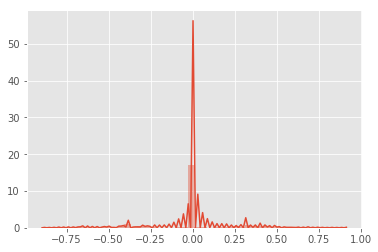

In [87]:
sns.distplot(compound_list);

# word_cloud

In [88]:
neg_title = df_title_compound[df_title_compound['target'] == -1]
neg_title.head()

,title,compound,target
5,ULK1/2 Restricts the Formation of Inducible SI...,-0.3182,-1
11,Three cases of idiopathic eosinophilic enterit...,-0.2960,-1
12,Potential risk of viral transmission from flyi...,-0.2732,-1
30,Statins May Decrease the Fatality Rate of Midd...,-0.6705,-1
36,"The Applied Health Research Centre Mason, Dala...",-0.7650,-1


In [89]:
neg_string = []
for t in neg_title['title']:
    neg_string.append(t)
neg_string

['ULK1/2 Restricts the Formation of Inducible SINT- Speckles, Membraneless Organelles Controlling the Threshold of TBK1 Activation',
 'Three cases of idiopathic eosinophilic enteritis with chronic obstinate diarrhea in Japanese Black fattening cattle',
 'Potential risk of viral transmission from flying foxes to domestic animals and humans on the southern coast of West Java, Indonesia',
 'Statins May Decrease the Fatality Rate of Middle East Respiratory Syndrome Infection',
 'The Applied Health Research Centre Mason, Dalah; Hospital for Sick Children, Child Health Evaluative Sciences Kowal, Christine; Hospital for Sick Children',
 'Risk Management and Healthcare Policy Dovepress Critical role of ethics in clinical management and public health response to the West Africa Ebola epidemic',
 'An Appropriate Lower Respiratory Tract Specimen Is Essential for Diagnosis of Middle East Respiratory Syndrome (MERS)',
 'Quantitative Proteomic Analysis of A549 Cells Infected with Human Respiratory S

# Negative sentiment

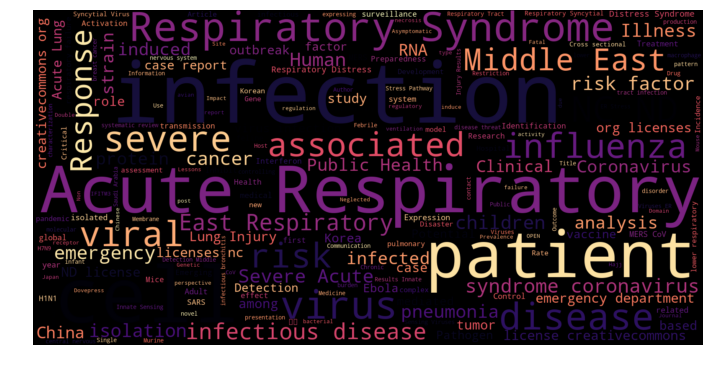

In [90]:
neg_title = df_title_compound[df_title_compound['target'] == -1]
neg_string = []
for t in neg_title['title']:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Positive sentiment

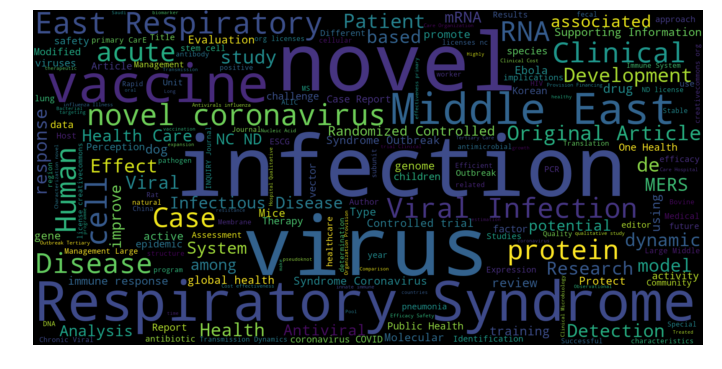

In [91]:
pos_title = df_title_compound[df_title_compound['target'] == 1]
pos_string = []
for t in pos_title['title']:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Neutral sentiment

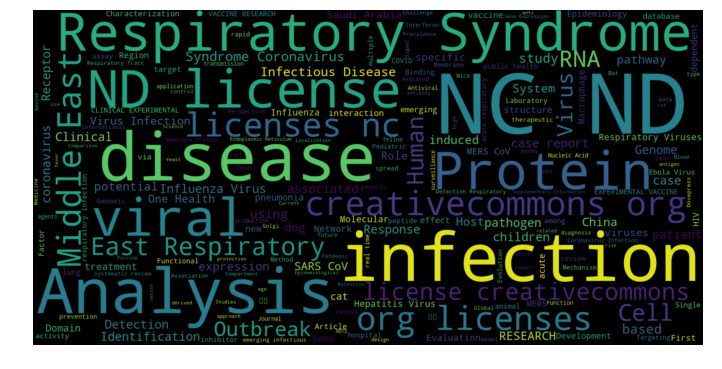

In [92]:
neut_title = df_title_compound[df_title_compound['target'] == 0]
neut_string = []
for t in neut_title['title']:
    neut_string.append(t)
neut_string = pd.Series(neut_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neut_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()